In [1]:
import jax.numpy as np
from scipy.special import j1
import jax.random as jr
import matplotlib.pyplot as plt
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu

In [2]:
min_wavelength = 560e-9
max_wavelength = 610e-9
delta_wavelength = max_wavelength - min_wavelength
n_wavelengths = 1024

period = 300e-6
diameter = 0.125

wavelengths = np.linspace(min_wavelength, max_wavelength, n_wavelengths)

# percentage over in xvals: 10% of wavlength range
x_buffer = 0.1

min_x = (np.sqrt(2)/period) * (min_wavelength - x_buffer * delta_wavelength)
max_x = (np.sqrt(2)/period) * (max_wavelength + x_buffer * delta_wavelength)

# adding lots of x values to sample
n_x = int(np.ceil((1+2*x_buffer)*n_wavelengths))

x = np.linspace(min_x, max_x, n_x)

In [3]:
# code for generating an arbitrary flux spectrum:
key = jr.PRNGKey(5)

# Create a complex array of zeros
spectrum = np.zeros(n_wavelengths, dtype=np.complex64)

d_wl = wavelengths[1]-wavelengths[0]
fs = 1 / d_wl           # sampling frequency
freqs = np.fft.fftfreq(n_wavelengths, d=d_wl)

# Desired frequency band (in Hz)
f_low = 0

max_spec_freq = (np.sqrt(2)/period) * (diameter/min_wavelength)

f_high = 2 * max_spec_freq
# Get indices of freqs within band (positive freqs only)
band_mask = (freqs >= f_low) & (freqs <= f_high)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(n_wavelengths,)) * band_mask
random_phases = jr.uniform(phase_key, shape=(n_wavelengths,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:n_wavelengths//2].set(spec[1:n_wavelengths//2])
    spec = spec.at[-(n_wavelengths//2)+1:].set(np.conj(spec[1:n_wavelengths//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)

signal = np.fft.ifft(spectrum).real
spectrum_filtered_bad = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
signal_filtered_bad = np.fft.ifft(spectrum_filtered_bad).real

#plt.plot(signal)

if np.min(signal) <= 0:
    signal_filtered_bad += -2*np.min(signal)
    signal += -2*np.min(signal)

In [18]:
def mellin(wavelengths, weights, freqs):
    d_wl = wavelengths[1]-wavelengths[0]
    mell = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        mel = np.sum(weights * wavelengths**(-1j * freq - 1) * d_wl)
        mell = mell.at[idx].set(mel)
    return mell

def inverse_mellin(freqs, melweights, wavelengths):
    d_freq = freqs[1]-freqs[0]
    inv_mell = np.zeros_like(wavelengths, dtype=np.complex64)
    for idx, wl, in enumerate(wavelengths):
        inv_mel = np.sum(melweights*wl**(1j * freqs) * d_freq)
        inv_mell = inv_mell.at[idx].set(inv_mel)
    inv_mell *= 1/(2*np.pi)
    return inv_mell

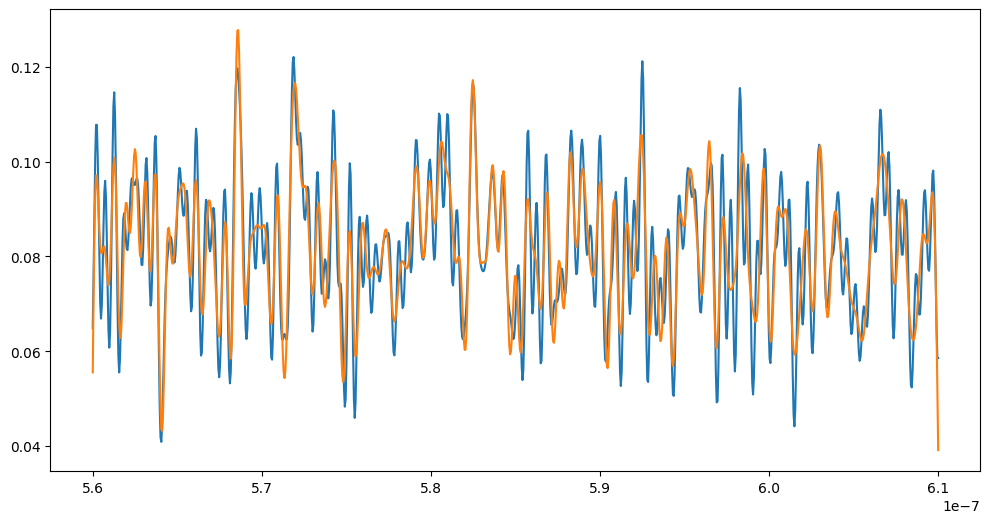

In [29]:
max_freq = 6000
freqs = np.linspace(-max_freq,max_freq,1024)
melweights = mellin(wavelengths,signal,freqs)
inv_mellin = inverse_mellin(freqs, melweights, wavelengths)

plt.figure(figsize=(12,6))
plt.plot(wavelengths, signal)
plt.plot(wavelengths, inv_mellin.real)
plt.show()

In [30]:
# defining the other functions
# Set default precision (digits)

import mpmath as mp


mp.mp.dps = 50  # you can adjust this for more precision


def hyper_pfq_regularized(a_list, b_list, z):
    """
    Compute the regularized generalized hypergeometric function:
    _pF_q(a_list; b_list; z) / (Gamma(b1)*...*Gamma(bq))
    """
    # numerator: ordinary hypergeometric pFq
    num = mp.hyper(a_list, b_list, z)
    # denominator: product of Gamma(b_j)
    denom = mp.mpf(1)
    for bj in b_list:
        denom *= mp.gamma(bj)
    return num / denom


def analytic_integral(a, omega, precision=50):
    """
    Compute
        1/2 * [ a*Γ(1 - iω/2)*Γ(3/2 + iω/2)*_2~3~F_reg(..., -a^2)
              +   Γ(1/2 - iω/2)*Γ(1 + iω/2)*_2~3~F_reg(..., -a^2) ]
    where _2~3~F_reg denotes the regularized HypergeometricPFQ.

    Parameters
    ----------
    a : float or complex
        Positive real offset in the integral.
    omega : float or complex
        Frequency at which to evaluate the transform.
    precision : int, optional
        Number of decimal digits of precision (default: 50).

    Returns
    -------
    mp.mpc
        The complex-valued result of the analytic integral.
    """
    # adjust precision
    mp.mp.dps = precision

    iomega = 1j * omega
    z = -a**2

    # first term
    t1 = (a
          * mp.e**(mp.loggamma(1 - iomega/2) + mp.loggamma(3/2 + iomega/2))
          * hyper_pfq_regularized(
                [0.5 + iomega/2, 1.5 + iomega/2],
                [1.5, 2 + iomega/2, 3 + iomega/2],
                z
            )
         )

    # second term
    t2 = (mp.e**(mp.loggamma(0.5 - iomega/2) + mp.loggamma(1 + iomega/2))
          * hyper_pfq_regularized(
                [1 + iomega/2, iomega/2],
                [0.5, 1.5 + iomega/2, 2.5 + iomega/2],
                z
            )
         )

    return 0.5 * (t1 + t2)

In [40]:
alpha = np.sqrt(2)/period
a = np.pi*diameter*alpha
h_list = []
for freq in freqs:
    h_list.append(analytic_integral(float(a), float(freq),8))
    print(freq)

-6000.0
-5988.27
-5976.5396
-5964.8096
-5953.079
-5941.349
-5929.6187
-5917.8887
-5906.158
-5894.428
-5882.698
-5870.968
-5859.238
-5847.5073
-5835.7773
-5824.047
-5812.317
-5800.5864
-5788.8564
-5777.126
-5765.396
-5753.666
-5741.9355
-5730.2056
-5718.475
-5706.745
-5695.0146
-5683.2847
-5671.554
-5659.824
-5648.094
-5636.364
-5624.634
-5612.903
-5601.173
-5589.443
-5577.7124
-5565.9824
-5554.252
-5542.522
-5530.7915
-5519.0615
-5507.331
-5495.601
-5483.871
-5472.1406
-5460.4106
-5448.68
-5436.95
-5425.2197
-5413.4897
-5401.7593
-5390.0293
-5378.299
-5366.569
-5354.839
-5343.1084
-5331.3784
-5319.648
-5307.918
-5296.1875
-5284.4575
-5272.727
-5260.997
-5249.267
-5237.5366
-5225.8066
-5214.076
-5202.346
-5190.6157
-5178.8857
-5167.1553
-5155.4253
-5143.695
-5131.965
-5120.235
-5108.5044
-5096.7744
-5085.044
-5073.314
-5061.5835
-5049.8535
-5038.123
-5026.393
-5014.663
-5002.9326
-4991.2026
-4979.472
-4967.742
-4956.0117
-4944.2817
-4932.5513
-4920.8213
-4909.0913
-4897.361
-4885.631
-4

In [43]:
dlu.rad2arcsec((585e-9)/(2*diameter)*np.sqrt(2))

Array(0.6825838, dtype=float32, weak_type=True)